Ridge regression and training/testing error code samples.
Examples by Prof. B. Hosseini

Text(0, 0.5, '$x_1$')

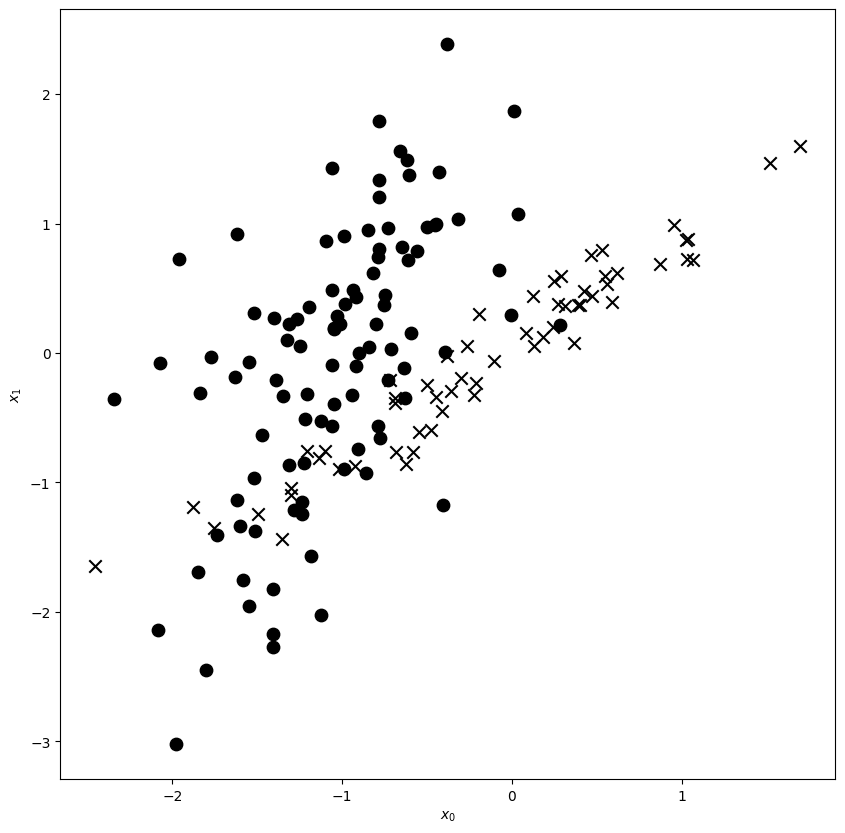

In [1]:
import numpy as np
import numpy.matlib 
import matplotlib.pyplot as plt

# same data set as Lec 12
N1 = 100
N2 = 60

C1 = [[0.5, 0.25], [0.25, 1]]
C2 = [[0.6, 0.4], [0.4, 0.5]]

M1 = np.matlib.repmat( np.array([[-1], [0]]), 1, N1 )
M2 = np.matlib.repmat( np.array([[0], [0.1]]), 1, N2 )

X1 = np.random.randn(2,N1)
X2 = np.random.randn(2,N2)

X = np.concatenate( (np.dot(C1, X1) + M1,  np.dot(C2, X2) + M2), axis=1)

Y = np.zeros((N1+N2))
Y[0:N1] = +1
Y[N1+1:None] = -1

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.scatter(X[0,0:N1], X[1,0:N1], s= 80, marker='o', c='k')
ax.scatter(X[0,N1+1:None], X[1,N1+1:None], s=80, marker='x', c='k')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

We will consider two models, one with quadratic polynomial feature maps $$(1, x_0, x_1, x_0^2, x_1^2, x_0x_1)$$ 
along with a *random feature* model where we choose $J\ge 1$ feature maps of the form $$\psi_j(x_1, x_2) = \exp(-(1/2w_{j0})(x_1 - w_{j1}) - (1/2w_{j2})(x_2 - w_{j3}))$$
where the $w_{jk}$ are iid Gaussian. 


In [2]:
# construct the A matrices 

# regression matrix for quadratic feature maps
A_quad = np.concatenate(( np.ones((N1+N2,1)), np.transpose(X), np.transpose(X**2), np.transpose(np.matrix((X[0,:]*X[1,:]))) ), axis = 1)

# regression matrix for random features

# first generate the features


np.random.seed(1)

J = 100 
w = 0.5*np.random.randn(J, 4) # each row corresponds to a feature map

def psi(w,x):

  # uncomment to try other random features or implement your own

  # val = np.exp( w[0]*(x[0] - w[1]) + w[2]*(x[1] - w[3]) ) # exp feature

  # val = np.maximum( 0, w[0]*x[0] + w[1]*x[1] + w[2] ) # ReLU features

  val = np.exp( -(1/(2*w[0]**2))*(x[0] - w[1])**2 - (1/(2*w[2]**2))*(x[1] - w[3])**2 ) # Gaussian features

  return val

A_rndf = np.zeros((N1+N2, J))
for j in range(J):
  for n in range(N1+N2):
    A_rndf[n, j] = psi( w[j,:], X[:,n])

A_quad = np.asarray(A_quad)
A_rndf = np.asarray(A_rndf)


We will now use scikitlearn to train both models. 

In [3]:
from sklearn import linear_model

# reg_quad = linear_model.Ridge(alpha=0.2) # alpha is our lambda
alphasvec = np.linspace(0.01,50,200)
reg_quad = linear_model.RidgeCV(alphas=alphasvec,cv=5) # alpha is our lambda


reg_quad.fit(A_quad, Y)

beta_quad = np.insert(reg_quad.coef_, 0, reg_quad.intercept_)

# reg_rndf = linear_model.Ridge(alpha=0.15) # alpha is our lambda
alphasvec = np.linspace(0.001,5,200)
reg_rndf = linear_model.RidgeCV(alphas=alphasvec,cv=5) # alpha is our lambda


# reg_rndf = linear_model.Ridge(alpha=0.01) # alpha is our lambda

reg_rndf.fit(A_rndf, Y)

beta_rndf = np.insert(reg_rndf.coef_, 0, reg_rndf.intercept_)


# visualize the fitted classifiers
x = np.linspace(-3.2, 3.2, 20)

y =x 

xv, yv = np.meshgrid( x, x )

def f_quad(x1, x2, b): 

  val = (b[0] + b[1]) + x1*b[2] + x2*b[3] + (x1**2)*b[4] + (x2**2)*b[5] + x1*x2*b[6]

  return val

def f_rndf(x1, x2, b):

  val = b[0]
  for j in range(1,J+1):
    
    val += b[j]*psi(w[j-1,:], [x1, x2])

  return val

f_quad_vals = f_quad( xv, yv, beta_quad )

f_rndf_vals = f_rndf( xv, yv, beta_rndf )


Text(0.5, 1.0, 'Random')

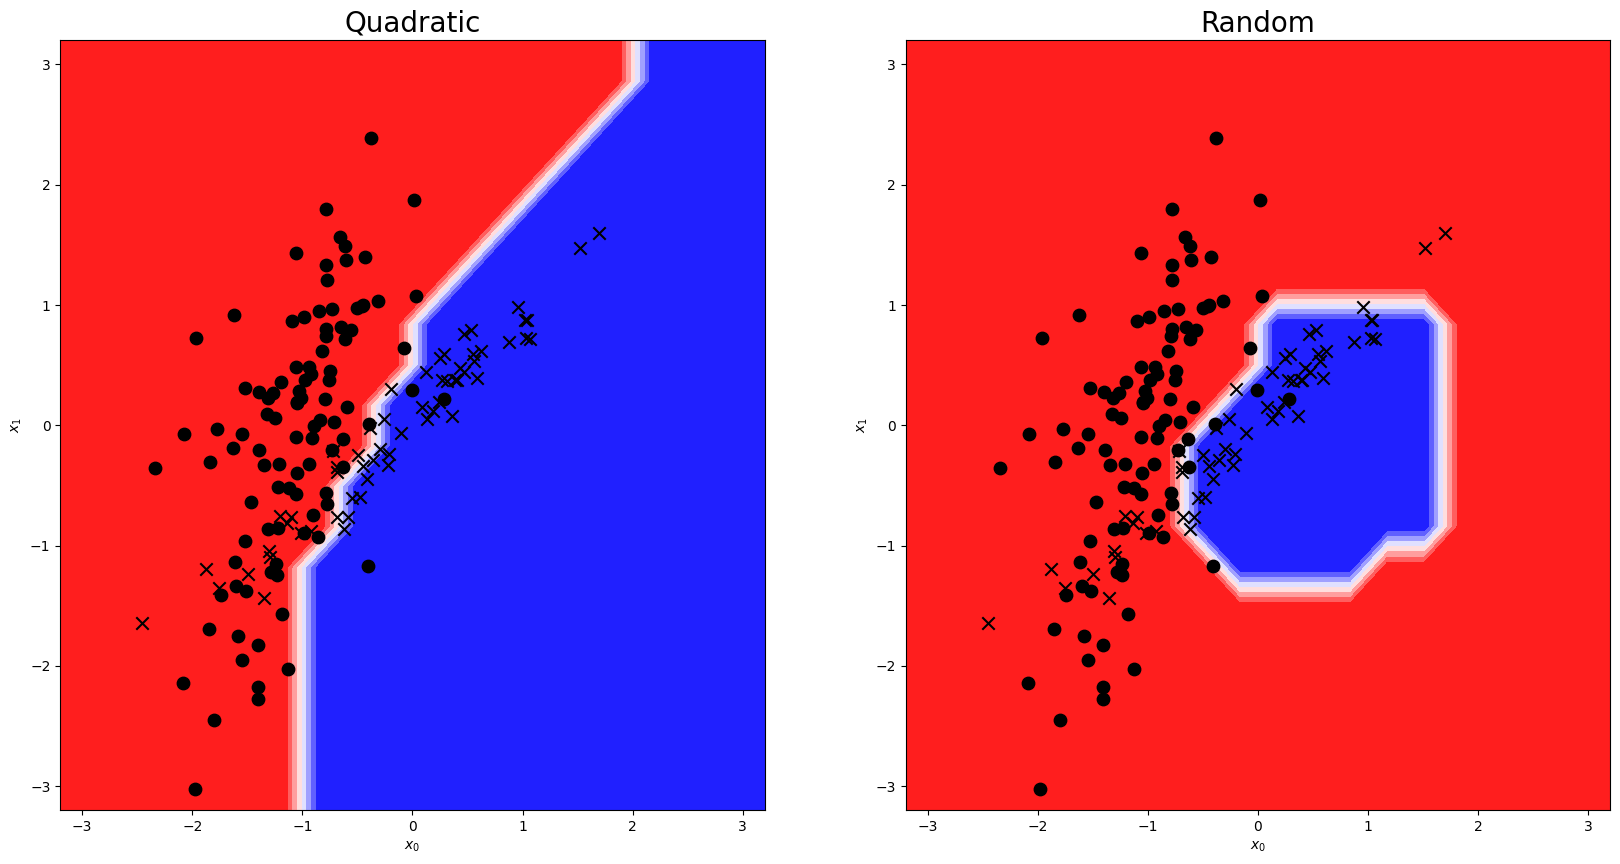

In [4]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].contourf(xv, yv, np.sign(f_quad_vals), cmap='bwr')
ax[0].scatter(X[0,0:N1], X[1,0:N1], s= 80, marker='o', c='k')
ax[0].scatter(X[0,N1+1:None], X[1,N1+1:None], s=80, marker='x', c='k')
ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('$x_1$')
ax[0].set_title('Quadratic', fontsize=20)


ax[1].contourf(xv, yv, np.sign(f_rndf_vals), cmap='bwr')
ax[1].scatter(X[0,0:N1], X[1,0:N1], s= 80, marker='o', c='k')
ax[1].scatter(X[0,N1+1:None], X[1,N1+1:None], s=80, marker='x', c='k')
ax[1].set_xlabel('$x_0$')
ax[1].set_ylabel('$x_1$')
ax[1].set_title('Random', fontsize=20)

We now generate a test set and evaluate both training and test errors of the two regression models. 

Text(0, 0.5, '$x_1$')

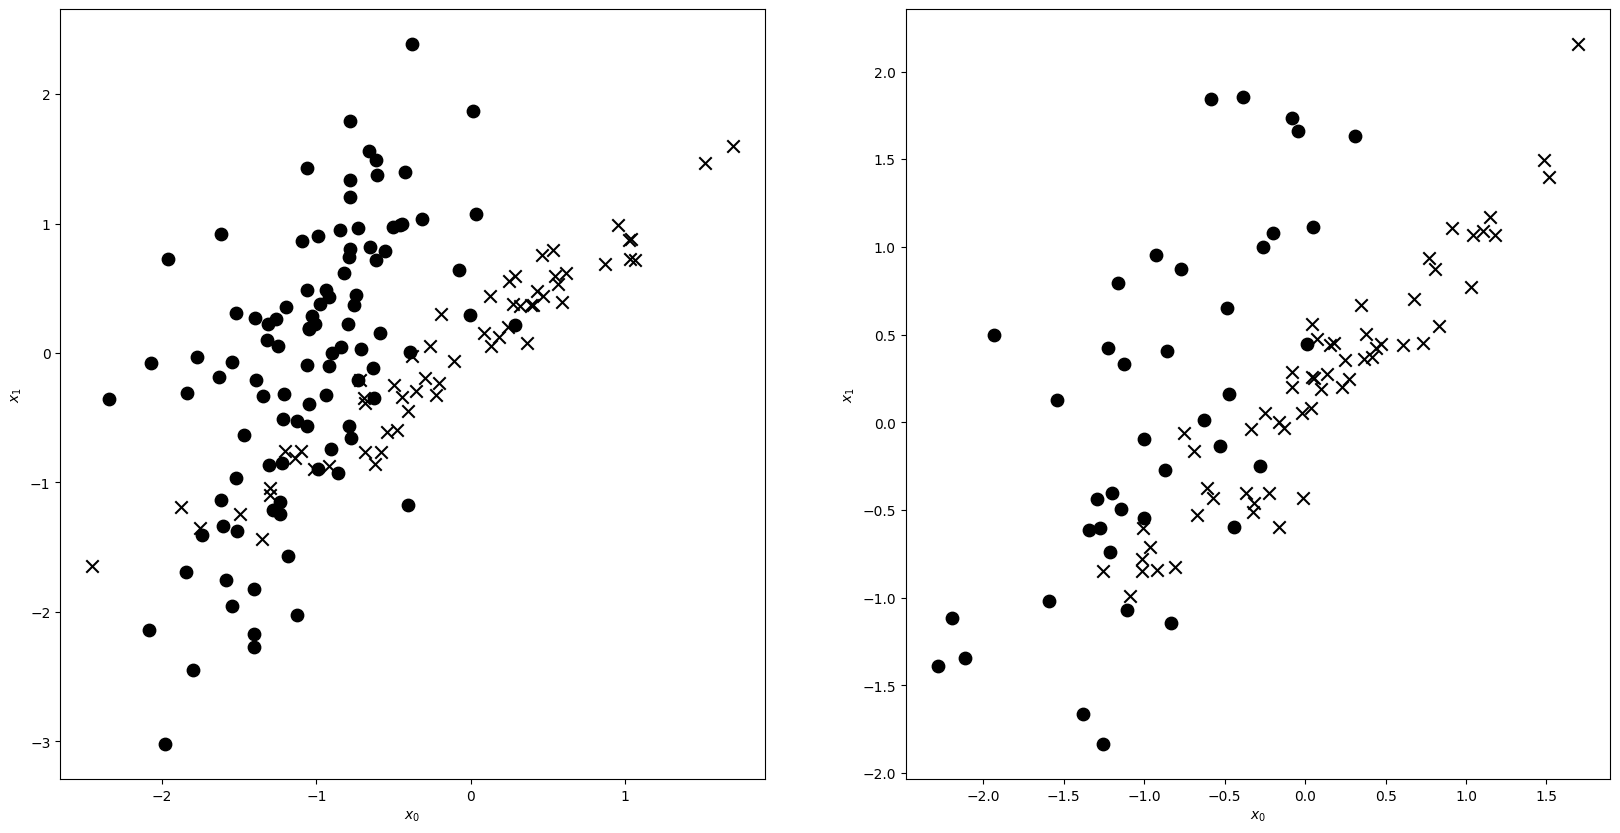

In [5]:
# generate test data in the same manner as training data

# same data set as Lec 12
N1_test = 40
N2_test = 60

X1_test = np.random.randn(2,N1_test)
X2_test = np.random.randn(2,N2_test)

M1_test = np.matlib.repmat( np.array([[-1], [0]]), 1, N1_test )
M2_test = np.matlib.repmat( np.array([[0], [0.1]]), 1, N2_test )

X_test = np.concatenate( (np.dot(C1, X1_test) + M1_test,  np.dot(C2, X2_test) + M2_test), axis=1)

Y_test = np.zeros((N1_test+N2_test))
Y_test[0:N1_test] = +1
Y_test[N1_test+1:None] = -1

# plot training and test sets next to each other 

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].scatter(X[0,0:N1], X[1,0:N1], s= 80, marker='o', c='k')
ax[0].scatter(X[0,N1+1:None], X[1,N1+1:None], s=80, marker='x', c='k')
ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('$x_1$')


ax[1].scatter(X_test[0,0:N1_test], X_test[1,0:N1_test], s= 80, marker='o', c='k')
ax[1].scatter(X_test[0,N1_test+1:None], X_test[1,N1_test+1:None], s=80, marker='x', c='k')
ax[1].set_xlabel('$x_0$')
ax[1].set_ylabel('$x_1$')

In [6]:

# compute MSE on both traning and test sets

MSE_quad_train= 1/(N1+ N2)*np.linalg.norm( f_quad(X[0,:], X[1,:], beta_quad) - Y )**2
print('MSE_quad_training: '+str(MSE_quad_train) )


MSE_rndf_train= 1/(N1+ N2)*np.linalg.norm( f_rndf(X[0,:], X[1,:], beta_rndf) - Y )**2
print('MSE_rndf_training: '+str(MSE_rndf_train) )


print('------')

MSE_quad_test= 1/(N1_test+ N2_test)*np.linalg.norm( f_quad(X_test[0,:], X_test[1,:], beta_quad) - Y_test )**2
print('MSE_quad_test: '+str(MSE_quad_test) )


MSE_rndf_test= 1/(N1_test+ N2_test)*np.linalg.norm( f_rndf(X_test[0,:], X_test[1,:], beta_rndf) - Y_test )**2
print('MSE_rndf_test: '+str(MSE_rndf_test) )



MSE_quad_training: 0.4734316233150644
MSE_rndf_training: 0.3810440524745447
------
MSE_quad_test: 0.4516554029884853
MSE_rndf_test: 0.5359633808580337
